In [1]:
import scipy
import scipy.stats
import numpy as np
import random
import pylab
from keras.layers import Dense
from keras.models import Sequential
from collections import defaultdict

MINPRICE = 3000
MAXPRICE = 4600
INITIALPRICE = 3800


# 환경
class Env:
    def __init__(self):
        self.action_space = ['u', 'l', 'c', 'r', 'd'] # 행동 순서대로 -80, -20, 0, +20, +80
        self.n_actions = len(self.action_space)  # 5 actions
        self.marketPrice = INITIALPRICE            # InitialPrice
        self.p_array = np.random.normal(self.marketPrice, 190, 500) #Passenger의 선호 가격 리스트
        self.p_count = len(self.p_array)                                  #승객의 수 초기 500명
        self.d_array = np.random.normal(self.marketPrice, 190, 500) #Driver의 선호 가격 리스트
        self.d_count = len(self.d_array)                                  #운전자 수 초기 500명
        #만족도옵션 추가
        
    #승객이 가격승낙할 확률
    def acceptP(self, offer, preferred):
        num = 0
        for i in preferred:
            x = (-offer + i) / 1600 
            # 누적분포 확률이용
            if np.random.rand() <= scipy.stats.norm(0, 1).cdf(x):
                num += 1
        return num
        
    #운전자가 가격승낙할 확률
    def acceptD(self, offer, preferred):
        num = 0
        for i in preferred:
            x = (offer - i) / 1600
            # 누적분포 확률이용
            if np.random.rand() <= scipy.stats.norm(0, 1).cdf(x):
                num += 1
        return num
        
        
    def step(self, action, count):
        
        if   action == 0:   # up : price-=80
            count=0
            self.marketPrice-=80
            
        elif action == 1:   # left : price-=20
            count=0
            self.marketPrice-=20
            
        elif action == 2:   # center : Nothing happen
            count+=1
            
        elif action == 3:   # right : price+=20
            count=0
            self.marketPrice+=20

        elif action == 4:   # down : price+=80
            count=0
            self.marketPrice+=80


        next_state = self.marketPrice
        reward = 0

        #보상 = next_state가격에서의 (match성사수) * (match 성사가격)
        p_ok = self.acceptP(next_state, self.p_array)
        d_ok = self.acceptD(next_state, self.d_array)
        match = min([p_ok, d_ok])
        reward = match * (next_state/1000)
        
        #보상 가격허용치를 넘으면 -100
        if next_state < MINPRICE or next_state > MAXPRICE:
            reward = -100
        
#         # 10번 state변화 없으면 done
#         done = False
#         if count==10:
#             done = True
        
        
        return next_state, reward
        
            
    def reset(self):
        self.marketPrice = INITIALPRICE
        self.p_array = np.random.normal(self.marketPrice, 190, 500) #Passenger의 선호 가격 리스트
        self.d_array = np.random.normal(self.marketPrice, 190, 500) #Driver의 선호 가격 리스트

        return self.marketPrice
        
# 가격 Agent
class priceActionModel:
    def __init__(self, actions):
        # 행동 = [0, 1, 2, 3, 4] 순서대로 -80, -20, 0, +20, +80
        self.actions = actions
        self.learning_rate = 0.01
        self.discount_factor = 0.9
        # epsilon_min, decay
        self.epsilon = 0.1
        self.q_table = defaultdict(lambda: [0.0, 0.0, 0.0, 0.0, 0.0]) # 5열
        
    # <s, a, r, s'> 샘플로부터 큐함수 업데이트
    def learn(self, state, action, reward, next_state):
        q_1 = self.q_table[state][action]
        # 벨만 최적 방정식을 사용한 큐함수의 업데이트
        q_2 = reward + self.discount_factor * max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (q_2 - q_1)
    
    # 큐함수에 의거하여 입실론 탐욕 정책에 따라서 행동을 반환
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            # 10% 확률로 무작위 행동 반환
            action = np.random.choice(self.actions)
        else:
            # 큐함수에 따른 행동 반환
            print(state, self.q_table[state])
            state_action = self.q_table[state]
            action = self.arg_max(state_action)
        return action
        
    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)
    
if __name__ == "__main__":
    
    env = Env()
    agent = priceActionModel(actions=list(range(env.n_actions)))            # [0, 1, 2, 3, 4]
    
    global_step = 0
    scores, episodes = [], []
    
    
    for episode in range(20):
        state = env.reset()
        count = 0
        
        for i in range(50000):
            global_step += 1

            # 현재 상태에 대한 행동 선택
            action = agent.get_action(str(state))
            
            # 행동을 취한 후 다음 상태, 보상 에피소드의 종료여부를 받아옴
            next_state, reward = env.step(action, count)

            # <s,a,r,s'>로 큐함수를 업데이트
            agent.learn(str(state), action, reward, str(next_state))
            state = next_state
            # 모든 큐함수를 화면에 표시
#           env.print_value_all(agent.q_table)

           
            scores.append(state)
            episodes.append(episode*50000 + i)
            pylab.plot(episodes, scores, 'b')
            pylab.savefig("./DP_graph.png")
            print("episode:", episode, "  score:", state, " global_step:",
                  global_step, "  epsilon:", agent.epsilon)
            

Using TensorFlow backend.


episode: 0   score: 3780  global_step: 1   epsilon: 0.1
episode: 0   score: 3760  global_step: 2   epsilon: 0.1
episode: 0   score: 3840  global_step: 3   epsilon: 0.1
episode: 0   score: 3840  global_step: 4   epsilon: 0.1
episode: 0   score: 3840  global_step: 5   epsilon: 0.1
episode: 0   score: 3840  global_step: 6   epsilon: 0.1
episode: 0   score: 3840  global_step: 7   epsilon: 0.1
episode: 0   score: 3840  global_step: 8   epsilon: 0.1
episode: 0   score: 3840  global_step: 9   epsilon: 0.1
episode: 0   score: 3840  global_step: 10   epsilon: 0.1
episode: 0   score: 3860  global_step: 11   epsilon: 0.1
episode: 0   score: 3880  global_step: 12   epsilon: 0.1
episode: 0   score: 3900  global_step: 13   epsilon: 0.1
episode: 0   score: 3920  global_step: 14   epsilon: 0.1
episode: 0   score: 3900  global_step: 15   epsilon: 0.1
episode: 0   score: 3920  global_step: 16   epsilon: 0.1
episode: 0   score: 3900  global_step: 17   epsilon: 0.1
episode: 0   score: 3920  global_step: 1

KeyboardInterrupt: 

In [7]:
import numpy as np
rewards = []
goal = []
def set_reward(state, reward):
        state = [int(state[0]), int(state[1])]
        x = int(state[0])
        y = int(state[1])
        temp = {}
        if reward > 0:
            temp['reward'] = reward
          

            goal.append(temp['reward'])


        elif reward < 0:
            temp['direction'] = -1
            temp['reward'] = reward
           

       
        temp['state'] = state
        rewards.append(temp)
        
        
set_reward([0, 1], -1)
set_reward([1, 2], -1)
set_reward([2, 3], -1)
set_reward([4, 4], 1)
print(rewards)
print(goal)

[{'direction': -1, 'reward': -1, 'state': [0, 1]}, {'direction': -1, 'reward': -1, 'state': [1, 2]}, {'direction': -1, 'reward': -1, 'state': [2, 3]}, {'reward': 1, 'state': [4, 4]}]
[1]


In [2]:
import tqdm
for i in tqdm.tqdm(range(1000)):
    pass

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 999834.09it/s]


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pickle as pkl

with open('./DBs.pkl', 'rb')as f:
    df = pkl.load(f)

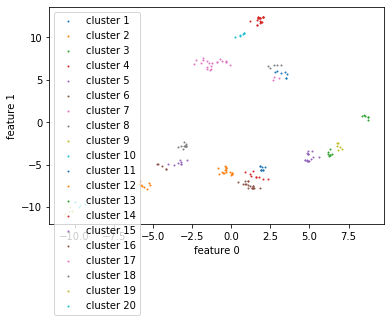

In [15]:
df_ftm1 = df[df[:,2]==-1, :] # 클러스터 -1 추출
df_ft0 = df[df[:,2]==0, :] # 클러스터 0 추출
df_ft1 = df[df[:,2]==1, :] # 클러스터 1 추출
df_ft2 = df[df[:,2]==2, :] # 클러스터 2 추출
df_ft3 = df[df[:,2]==3, :] # 클러스터 3 추출
df_ft4 = df[df[:,2]==4, :] # 클러스터 4 추출
df_ft5 = df[df[:,2]==5, :] # 클러스터 5 추출
df_ft6 = df[df[:,2]==6, :] # 클러스터 6 추출
df_ft7 = df[df[:,2]==7, :] # 클러스터 7 추출
df_ft8 = df[df[:,2]==8, :] # 클러스터 8 추출
df_ft9 = df[df[:,2]==9, :] # 클러스터 9 추출
df_ft10 = df[df[:,2]==10, :] # 클러스터 10 추출
df_ft11 = df[df[:,2]==11, :] # 클러스터 11 추출
df_ft12 = df[df[:,2]==12, :] # 클러스터 12 추출
df_ft13 = df[df[:,2]==13, :] # 클러스터 13 추출
df_ft14 = df[df[:,2]==14, :] # 클러스터 14 추출
df_ft15 = df[df[:,2]==15, :] # 클러스터 15 추출
df_ft16 = df[df[:,2]==16, :] # 클러스터 16 추출
df_ft17 = df[df[:,2]==17, :] # 클러스터 17 추출
df_ft18 = df[df[:,2]==18, :] # 클러스터 18 추출
df_ft19 = df[df[:,2]==19, :] # 클러스터 19 추출
df_ft20 = df[df[:,2]==20, :] # 클러스터 20 추출
# matplotlib로 그래프 그리기
# plt.scatter(df_ftm1[:, 0], df_ftm1[:, 1], label='cluster -1', cmap='Pairs', s=1) 
# plt.scatter(df_ft0[:, 0], df_ft0[:, 1], label='cluster 0', cmap='Pairs', s=1)
plt.scatter(df_ft1[:, 0], df_ft1[:, 1], label='cluster 1', cmap='Pairs', s=1)
plt.scatter(df_ft2[:, 0], df_ft2[:, 1], label='cluster 2', cmap='Pairs', s=1)
plt.scatter(df_ft3[:, 0], df_ft3[:, 1], label='cluster 3', cmap='Pairs', s=1)
plt.scatter(df_ft4[:, 0], df_ft4[:, 1], label='cluster 4', cmap='Pairs', s=1)
plt.scatter(df_ft5[:, 0], df_ft5[:, 1], label='cluster 5', cmap='Pairs', s=1)
plt.scatter(df_ft6[:, 0], df_ft6[:, 1], label='cluster 6', cmap='Pairs', s=1)
plt.scatter(df_ft7[:, 0], df_ft7[:, 1], label='cluster 7', cmap='Pairs', s=1)
plt.scatter(df_ft8[:, 0], df_ft8[:, 1], label='cluster 8', cmap='Pairs', s=1)
plt.scatter(df_ft9[:, 0], df_ft9[:, 1], label='cluster 9', cmap='Pairs', s=1)
plt.scatter(df_ft10[:, 0], df_ft10[:, 1], label='cluster 10', cmap='Pairs', s=1)
plt.scatter(df_ft11[:, 0], df_ft11[:, 1], label='cluster 11', cmap='Pairs', s=1)
plt.scatter(df_ft12[:, 0], df_ft12[:, 1], label='cluster 12', cmap='Pairs', s=1)
plt.scatter(df_ft13[:, 0], df_ft13[:, 1], label='cluster 13', cmap='Pairs', s=1)
plt.scatter(df_ft14[:, 0], df_ft14[:, 1], label='cluster 14', cmap='Pairs', s=1)
plt.scatter(df_ft15[:, 0], df_ft15[:, 1], label='cluster 15', cmap='Pairs', s=1)
plt.scatter(df_ft16[:, 0], df_ft16[:, 1], label='cluster 16', cmap='Pairs', s=1)
plt.scatter(df_ft17[:, 0], df_ft17[:, 1], label='cluster 17', cmap='Pairs', s=1)
plt.scatter(df_ft18[:, 0], df_ft18[:, 1], label='cluster 18', cmap='Pairs', s=1)
plt.scatter(df_ft19[:, 0], df_ft19[:, 1], label='cluster 19', cmap='Pairs', s=1)
plt.scatter(df_ft20[:, 0], df_ft20[:, 1], label='cluster 20', cmap='Pairs', s=1)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend()
plt.show()